<a href="https://colab.research.google.com/github/muhammad-madridista/IntroductionToPytorch/blob/main/SarcasmDetectionUsingBertModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers --quiet
!pip install opendatasets --quiet

import opendatasets as od
od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection")
#od.download("https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection/download

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhammadmadridista98
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection


100%|██████████| 3.30M/3.30M [00:00<00:00, 806MB/s]

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device='cuda' if torch.cuda.is_available() else 'cpu'
print("Available:", device)

Available: cuda


In [4]:
data_df=pd.read_json('/content/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json',lines=True)
data_df.dropna(inplace=True)
data_df.drop(["article_link"], inplace=True, axis=1)
print(data_df.shape)
data_df.head()

(26709, 2)


,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(np.array(data_df['headline']), np.array(data_df['is_sarcastic']), test_size=0.2, random_state=42)
X_val,X_test,y_val,y_test=train_test_split(X_test,y_test,test_size=0.5,random_state=42)

print("Training Size:", X_train.shape[0], " rows Which is: ", round(X_train.shape[0]/data_df.shape[0],4) * 100, "%" )
print("Validation Size:", X_val.shape[0], " rows Which is: ", round(X_val.shape[0]/data_df.shape[0],4) * 100, "%" )
print("Training Size:", X_test.shape[0], "rows Which is: ", round(X_test.shape[0]/data_df.shape[0],4) * 100, "%" )

Training Size: 21367  rows Which is:  80.0 %
Validation Size: 2671  rows Which is:  10.0 %
Training Size: 2671 rows Which is:  10.0 %


In [6]:
tokenizer=AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')
bert_model=AutoModel.from_pretrained('google-bert/bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [7]:
class dataset(Dataset):
  def __init__(self,X,Y):
    self.X=[tokenizer(x,max_length=100, truncation=True,padding='max_length',return_tensors='pt').to(device) for x in X]
    self.Y=torch.tensor(Y,dtype=torch.long).to(device)
  def __len__(self):
    return len(self.X)
  def __getitem__(self,idx):
    return self.X[idx],self.Y[idx]

training_data=dataset(X_train,y_train)
validation_data=dataset(X_val,y_val)
testing_data=dataset(X_test,y_test)

In [8]:
BATCH_SIZE=32
EPOCHS=10
LR=1e-4

In [9]:
train_dataloader=DataLoader(training_data,batch_size=BATCH_SIZE,shuffle=True)
validation_dataloader=DataLoader(validation_data,batch_size=BATCH_SIZE,shuffle=True)
testing_dataloader=DataLoader(testing_data,batch_size=BATCH_SIZE,shuffle=True)

In [10]:
class MyModel(nn.Module):
  def __init__(self,bert):
    super(MyModel,self).__init__()
    self.bert=bert
    self.dropout=nn.Dropout(0.1) # Correctly instantiate Dropout with a probability
    self.linear1=nn.Linear(768,384)
    self.linear2=nn.Linear(384,1)
    #self.relu=nn.ReLU()
    self.sigmoid=nn.Sigmoid()

  def forward(self,input_ids,attention_mask):
    pooled_output=self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)[0][:,0]
    output=self.linear1(pooled_output)
    output=self.dropout(output)
    output=self.linear2(output)
    output=self.sigmoid(output)
    return output

In [11]:
for param in bert_model.parameters():
  param.requires_grad=False

model=MyModel(bert_model).to(device)

In [12]:
model

MyModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [13]:
criterion=nn.BCELoss()
optimizer=optim.Adam(model.parameters(),lr=LR)

In [14]:
total_loss_train_plot=[]
total_loss_validation_plot=[]
total_acc_train_plot=[]
total_acc_validation_plot=[]

for epoch in range(EPOCHS):
  total_acc_train=0
  total_acc_validation=0
  total_loss_train=0
  total_loss_validation=0 # Initialize validation loss for the current epoch

  # Training loop
  #model.train() # Set model to training mode
  for indx, data in enumerate(train_dataloader):
    inputs, labels=data

    prediction=model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)
    batch_loss=criterion(prediction,labels.float()) # Ensure labels are float for BCELoss
    total_loss_train+=batch_loss.item()

    acc=(prediction.round()==labels).sum().item()
    total_acc_train+=acc
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  # Validation loop (moved inside the epoch loop)
  #model.eval() # Set model to evaluation mode
  with torch.no_grad():
    for indx, data in enumerate(validation_dataloader):
      inputs, labels=data

      prediction=model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)
      batch_loss=criterion(prediction,labels.float()) # Ensure labels are float for BCELoss
      total_loss_validation+=batch_loss.item() # Use total_loss_validation consistently

      acc=(prediction.round()==labels).sum().item()
      total_acc_validation+=acc # Use total_acc_validation consistently

  # Append epoch results to plots
  total_loss_train_plot.append(round(total_loss_train/len(train_dataloader), 4)) # Divide by num batches for average loss
  total_loss_validation_plot.append(round(total_loss_validation/len(validation_dataloader), 4)) # Divide by num batches for average loss
  total_acc_train_plot.append(round(total_acc_train/training_data.__len__()*100,4))
  total_acc_validation_plot.append(round(total_acc_validation/validation_data.__len__()*100,4)) # Corrected typo

  print(f"""
Epochs: {epoch+1} Train Loss: {round(total_loss_train/len(train_dataloader),4)} Train Accuracy: {round(total_acc_train/training_data.__len__()*100,4)}
      Validation Loss: {round(total_loss_validation/len(validation_dataloader),4)} Validation Accuracy: {round(total_acc_validation/validation_data.__len__()*100,4)}
  """)


Epochs: 1 Train Loss: 0.4348 Train Accuracy: 80.7132
      Validation Loss: 0.3785 Validation Accuracy: 84.7997
  

Epochs: 2 Train Loss: 0.3528 Train Accuracy: 84.8224
      Validation Loss: 0.3587 Validation Accuracy: 84.6125
  

Epochs: 3 Train Loss: 0.3324 Train Accuracy: 85.7257
      Validation Loss: 0.3426 Validation Accuracy: 85.7357
  

Epochs: 4 Train Loss: 0.3217 Train Accuracy: 86.1515
      Validation Loss: 0.3376 Validation Accuracy: 86.784
  

Epochs: 5 Train Loss: 0.3152 Train Accuracy: 86.3855
      Validation Loss: 0.3373 Validation Accuracy: 86.8589
  

Epochs: 6 Train Loss: 0.3122 Train Accuracy: 86.5681
      Validation Loss: 0.3291 Validation Accuracy: 86.7465
  

Epochs: 7 Train Loss: 0.3068 Train Accuracy: 86.6523
      Validation Loss: 0.3341 Validation Accuracy: 86.5968
  

Epochs: 8 Train Loss: 0.3061 Train Accuracy: 86.877
      Validation Loss: 0.33 Validation Accuracy: 86.784
  

Epochs: 9 Train Loss: 0.3028 Train Accuracy: 87.0782
      Validation Loss: 

In [15]:
with torch.no_grad():
  total_loss_test=0
  total_acc_test=0

  for index, data in enumerate(testing_dataloader):
    inputs, labels=data
    inputs.to(device)
    labels.to(device)

    prediction=model(inputs['input_ids'].squeeze(1),inputs['attention_mask'].squeeze(1)).squeeze(1)
    batch_loss=criterion(prediction,labels.float()) # Ensure labels are float for BCELoss
    total_loss_test+=batch_loss.item()

    acc=(prediction.round()==labels).sum().item()
    total_acc_test+=acc

print(f"Accuracy Score on testing Data is: {round(total_acc_test/testing_data.__len__()*100,4)}")


Accuracy Score on testing Data is: 86.3721


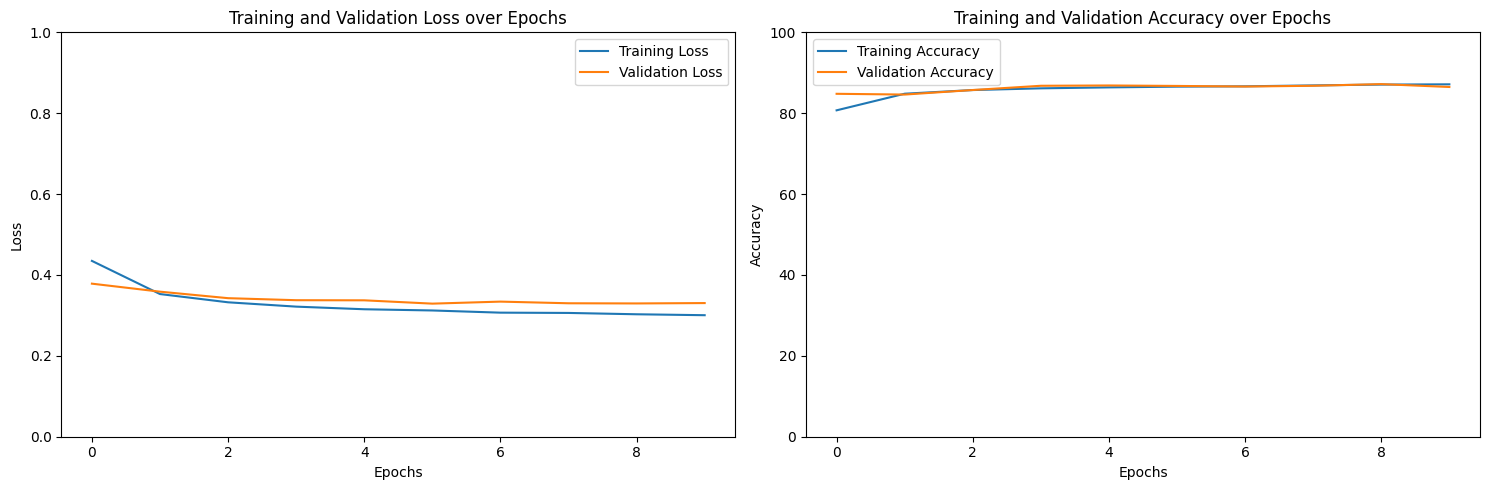

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title("Training and Validation Loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,1])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title("Training and Validation Accuracy over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([0,100])
axs[1].legend()

plt.tight_layout()
plt.show()

In [20]:
# Important: Please ensure all preceding cells have been executed, especially those defining 'model', 'tokenizer', and 'device'.

def predict_sarcasm(sentence):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        # Tokenize the input sentence
        inputs = tokenizer(sentence, max_length=100, truncation=True, padding='max_length', return_tensors='pt').to(device)

        # Get prediction from the model
        output = model(inputs['input_ids'].squeeze(1), inputs['attention_mask'].squeeze(1)).squeeze(1)

        # Convert output to binary prediction
        prediction = torch.round(output).item()

        if prediction == 1:
            return f"The sentence \"{sentence}\" is predicted to be Sarcastic."
        else:
            return f"The sentence \"{sentence}\" is predicted to be Not Sarcastic."

# Example usage:
sentence1 = "This is just brilliant, another day, another meeting."
sentence2 = "The weather is so lovely today, perfect for a walk."
sentence3 = "Oh, great! Another traffic jam. Just what I needed."
sentence4= "Says a person who got divroced three times"

print(predict_sarcasm(sentence1))
print(predict_sarcasm(sentence2))
print(predict_sarcasm(sentence3))
print(predict_sarcasm(sentence4))

The sentence "This is just brilliant, another day, another meeting." is predicted to be Not Sarcastic.
The sentence "The weather is so lovely today, perfect for a walk." is predicted to be Not Sarcastic.
The sentence "Oh, great! Another traffic jam. Just what I needed." is predicted to be Not Sarcastic.
The sentence "Says a person who got divroced three times" is predicted to be Sarcastic.


The `predict_sarcasm` function takes a single sentence (string) as input. It tokenizes the sentence, passes it through the trained BERT-based model, and returns a classification (Sarcastic or Not Sarcastic). You can call this function with any sentence you want to test.